# Factorial Kriging Analysis

<!-- SUMMARY: Filtering images using Factorial Kriging Analysis. Example on a multivariate acquisition  -->

<!-- CATEGORY: Courses -->

In [1]:
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import matplotlib.pyplot as plt
import numpy as np
import os

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

The Grid containing the information is downloaded from the distribution.

The loaded file (called **grid **) contains 3 variables:

- **P** (phosphorus) which is the *variable of interest*
- **Cr** (chromium) is an auxiliary variable
- **Ni** (nickel) another auxiliary variable


In [2]:
fileNF = gdoc.loadData("FKA", "Image.ascii")
grid = gl.DbGrid.createFromNF(fileNF)
ndim = 2
gl.defineDefaultSpace(gl.ESpaceType.RN, ndim)

In [3]:
dbfmt = gl.DbStringFormat()
dbfmt.setFlags(flag_resume=False,flag_vars=False,flag_stats=True, names="P")
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Statistics
--------------------
6 - Name P - Locator NA
 Nb of data          =     262144
 Nb of active values =     242306
 Minimum value       =      0.000
 Maximum value       =    314.000
 Mean value          =     31.767
 Standard Deviation  =     21.759
 Variance            =    473.457


Note that some pixels are not informed for variable **P**.

Statistics on auxiliary variables

In [4]:
dbfmt.setFlags(flag_vars=False, flag_resume=True, flag_stats=True, names=["Cr", "Ni"])
grid.display(dbfmt)


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 6
Total number of samples      = 262144

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      1.000     1.000
Number :        512       512

Data Base Statistics
--------------------
4 - Name Cr - Locator NA
 Nb of data          =     262144
 Nb of active values =     262144
 Minimum value       =   2591.000
 Maximum value       =  24982.000
 Mean value          =  16800.231
 Standard Deviation  =    936.213
 Variance            = 876495.558
5 - Name Ni - Locator NA
 Nb of data          =     262144
 Nb of active values =     262144
 Minimum value       =   1840.000
 Maximum value       =  12593.000
 Mean value          =  10111.444
 Standard Deviation  =    884.996
 Variance            = 783217.898


Correlation between variables

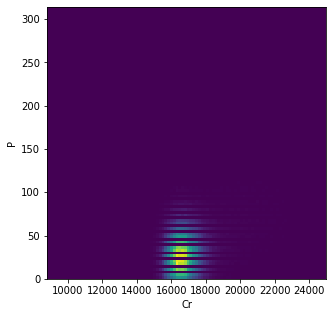

In [5]:
ax = gp.correlation(grid, namex="Cr", namey="P", bins=100)

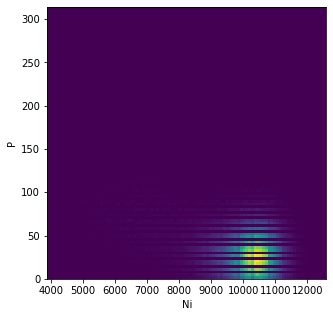

In [6]:
ax = gp.correlation(grid, namex="Ni", namey="P", bins=100)

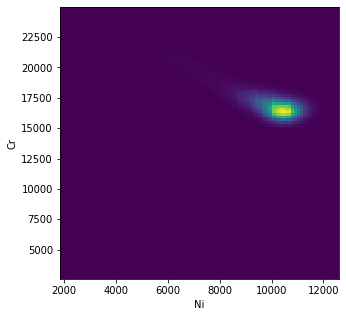

In [7]:
ax = gp.correlation(grid, namex="Ni", namey="Cr", bins=100)

Using inverse square distance for completing the variable **P**

In [8]:
grid.setLocator("P", gl.ELoc.Z)
err = gl.DbHelper.dbgrid_filling(grid,0,13432,1)

We concentrate on the variable of interest **P** completed (**Fill.P**) in the next operations

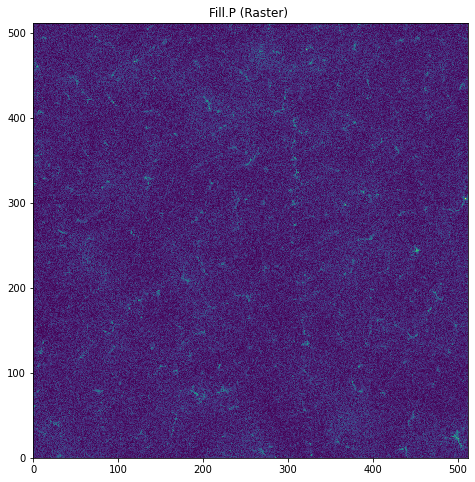

In [9]:
gp.setDefaultGeographic(dims=[8,8])
ax = grid.plot("Fill.P")

Variogram Calculation along Grid main axes

In [10]:
varioparam = gl.VarioParam.createMultipleFromGrid(grid, nlag=100)
varioP = gl.Vario(varioparam)
err = varioP.compute(grid)
modelP = gl.Model()
err = modelP.fit(varioP, types=[gl.ECov.NUGGET, gl.ECov.SPHERICAL, gl.ECov.POWER],
                 optvar=gl.Option_VarioFit(True, False))
modelP.setDriftIRF(0,0)

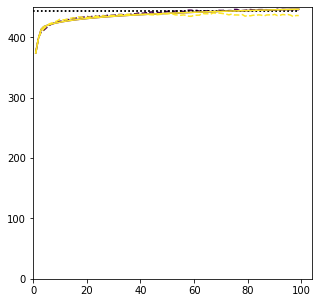

In [11]:
ax = gp.varmod(varioP, modelP)

We must define the **Neighborhood**

In [12]:
neigh = gl.NeighImage([10,10])

The **image** neighborhood is based on $(2*10+1)^2=441$ pixels (centered on the target pixel).

During the estimation, only the contribution of second and third basic structures are kept (Nugget Effect is filtered out): ** Factorial Kriging Analysis**.

In [13]:
modelP.setCovFiltered(0, True)
means = gl.dbStatisticsMono(grid,["Fill.P"],[gl.EStatOption.MEAN]).getValues()
modelP.setMeans(means)
modelP


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 3
Number of drift function(s)  = 1
Number of drift equation(s)  = 1

Covariance Part
---------------
Nugget Effect
- Sill         =    273.033
  (This component is Filtered)
Spherical
- Sill         =     56.100
- Range        =      3.598
Power (Third Parameter = 0.0879341)
- Slope        =      1.187


Drift Part
----------
Universality_Condition

In [14]:
err  = gl.krimage(grid,modelP,neigh,namconv=gl.NamingConvention("Mono"))

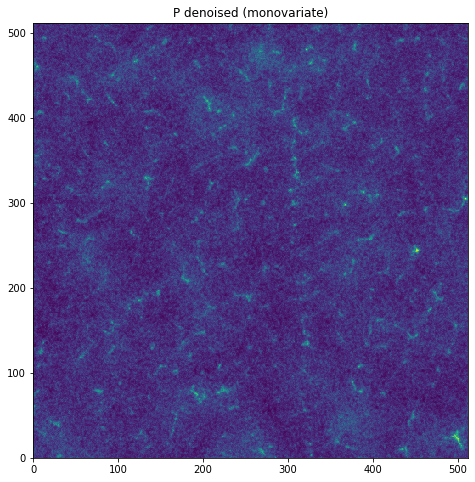

In [15]:
ax = grid.plot("Mono*.P")
ax.decoration(title="P denoised (monovariate)")

Correlation for **P** variable between Initial image (completed) and its Filtered version (monovariate FKA)

In [16]:
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 8
Total number of samples      = 262144

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      1.000     1.000
Number :        512       512

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2
Column = 3 - Name = Cr - Locator = NA
Column = 4 - Name = Ni - Locator = NA
Column = 5 - Name = P - Locator = NA
Column = 6 - Name = Fill.P - Locator = NA
Column = 7 - Name = Mono.Fill.P - Locator = z1

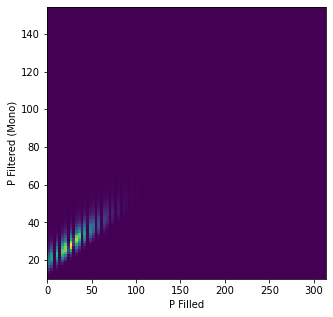

In [17]:
ax = gp.correlation(grid, namex="Fill.P", namey="Mono.Fill.P", bins=100)
ax.decoration(xlabel="P Filled",ylabel="P Filtered (Mono)")

## Multivariate approach

In [18]:
grid.setLocators(["Fill.P", "Cr", "Ni"], gl.ELoc.Z)

varioM = gl.Vario(varioparam)
err = varioM.compute(grid)
modelM = gl.Model()
err = modelM.fit(varioM, types=[gl.ECov.NUGGET, gl.ECov.SPHERICAL, gl.ECov.POWER],
                 optvar=gl.Option_VarioFit(True, False))
modelM.setDriftIRF(0,0)

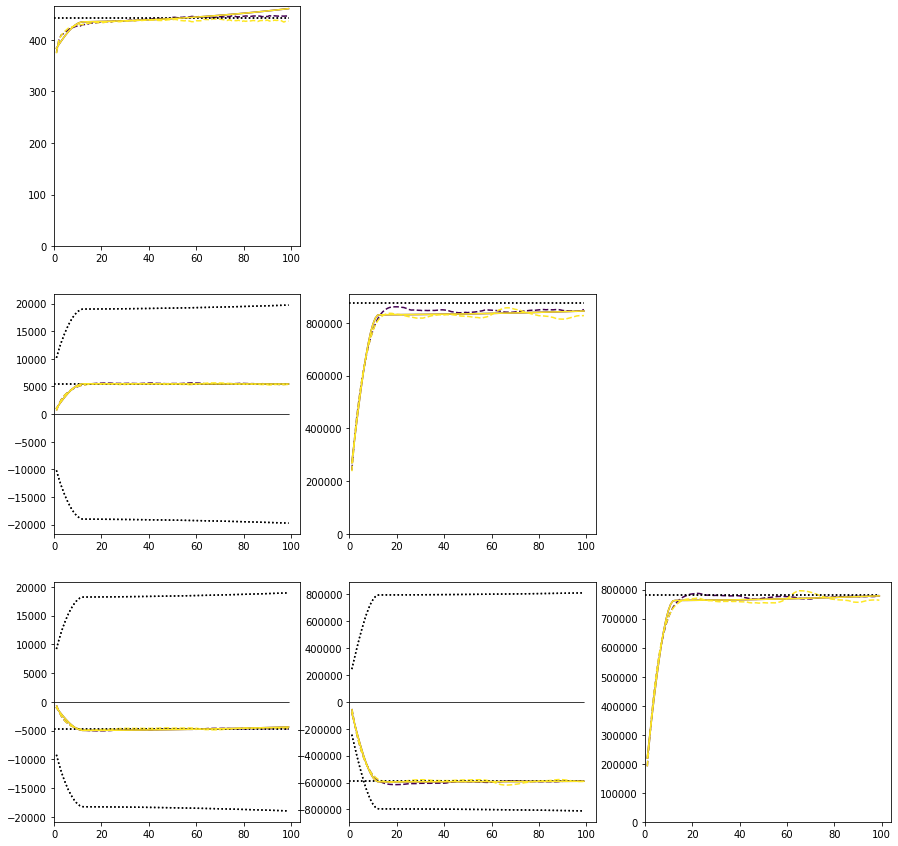

In [19]:
ax = gp.varmod(varioM, modelM)

Printing the contents of the fitted Multivariate Mpdel

In [20]:
modelM.setCovFiltered(0, True)
means = gl.dbStatisticsMono(grid,["Fill.P", "Cr", "Ni"],[gl.EStatOption.MEAN]).getValues()
modelM.setMeans(means)
modelM


Model characteristics
Space dimension              = 2
Number of variable(s)        = 3
Number of basic structure(s) = 3
Number of drift function(s)  = 1
Number of drift equation(s)  = 3

Covariance Part
---------------
Nugget Effect
- Sill matrix:
               [,  0]    [,  1]    [,  2]
     [  0,]   376.844   452.994  -476.682
     [  1,]   452.994194188.109-11524.845
     [  2,]  -476.682-11524.845145939.572
  (This component is Filtered)
Spherical
- Sill matrix:
               [,  0]    [,  1]    [,  2]
     [  0,]    57.518  5031.718 -4488.453
     [  1,]  5031.718636076.559-583291.704
     [  2,] -4488.453-583291.704616673.997
- Range        =     12.375
Power (Third Parameter = 1.99)
- Slope matrix:
               [,  0]    [,  1]    [,  2]
     [  0,]     0.262    -0.414     6.127
     [  1,]    -0.414   145.976    44.478
     [  2,]     6.127    44.478   163.446


Drift Part
----------
Universality_Condition

Multivariable Factorial Kriging Analysis

In [21]:
err  = gl.krimage(grid,modelM,neigh,namconv=gl.NamingConvention("Multi"))

Note that, using the same **neigh** as in monovariate, the dimension of the Kriging System is now $3 * 441 = 1323$

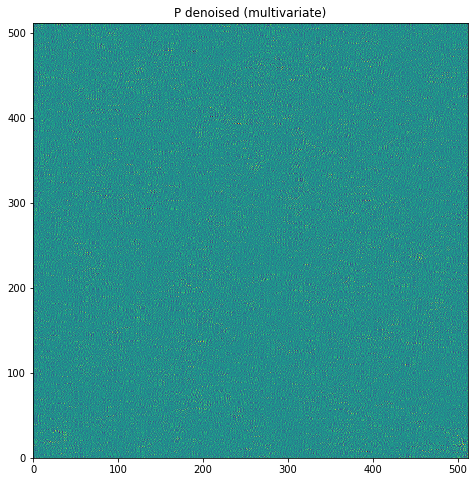

In [22]:
ax = grid.plot("Multi*.P")
ax.decoration(title="P denoised (multivariate)")

Correlation for **P** variable between Initial image and its Filtered version (multivariate FKA)

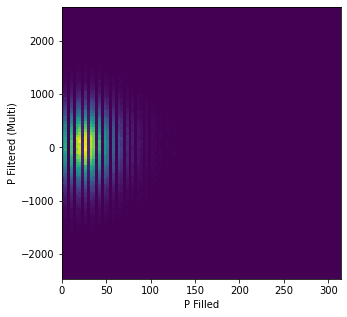

In [23]:
ax = gp.correlation(grid, namex="Fill.P", namey="Multi.Fill.P", bins=100)
ax.decoration(xlabel="P Filled",ylabel="P Filtered (Multi)")

Correlation for **P** filtered variable between the Monovariate and the Multivariate case

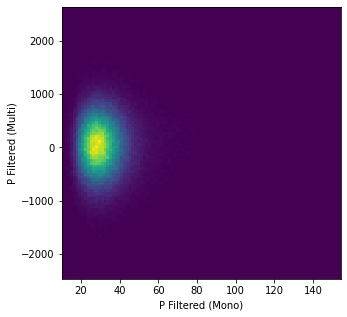

In [24]:
ax = gp.correlation(grid, namex="Mono.Fill.P", namey="Multi.Fill.P", bins=100)
ax.decoration(xlabel="P Filtered (Mono)",ylabel="P Filtered (Multi)")